In [3]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

In [4]:
# Download the Zillow Housing Dataset

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


Zillow Housing Price Prediction – Milestone 1 Notebook

Part 1: Frame the Problem and Look at the Big Picture

1.1: What is the objective of this project in business terms?

The primary objective of this project is to build a robust regression model that can accurately predict the assessed tax value (`taxvaluedollarcnt`) of residential properties using their physical characteristics, location features, and structural attributes. In business terms, this capability allows Zillow to enhance the accuracy of its automated valuation tools (e.g., Zestimate), thereby increasing user trust and engagement on its platform. A reliable model strengthens Zillow’s position as a market leader in real estate data analytics, providing better insights compared to competitors like Redfin, Trulia, or Realtor.com, and enabling Zillow to attract more buyers, sellers, and partnering agents.

1.2: How will your solution be used?

The solution will be integrated into Zillow’s data pipeline to generate real-time property value predictions for listings on its website and app. These predictions help users make informed buying or selling decisions, even in cases where recent comparable sales data is limited. Moreover, Zillow’s marketing and strategy teams can use these models to identify undervalued or overvalued properties, optimize targeted advertising campaigns, target promotional efforts more effectively, design campaigns that highlight properties with the best value-for-price ratios, and assess market trends by region. Additionally, the model can be used retrospectively to compare past predictions against actual historical sale prices, thereby evaluating and improving the performance and calibration of Zillow’s Automated Valuation Models over time. The model may also support internal analytics, portfolio evaluations, and partnerships with real estate professionals.

1.3: How should success (or failure) be measured?

Success should be measured by evaluating the model’s predictive accuracy using metrics such as Root Mean Squared Error (RMSE) or Mean Absolute Error (MAE) on a held-out test set (separate validation dataset), with lower values indicating better performance. From a business perspective, success also depends on whether the predicted values are close enough to actual market assessments to inform buying or selling decisions confidently, ideally within a reasonable percentage error margin (e.g. ±10-15%). Failure would be indicated by predictions that are systematically biased (model consistently underestimates or overestimates property values), highly variable, or misleading for users, thereby undermining trust in Zillow’s valuation tools which may result in poor business decisions and diminished competitive advantage in the real estate data market.

In [5]:
# View first 5 rows
print("First 5 rows:")
display(df.head())

First 5 rows:


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0


In [6]:
# Part 2.A

# Dataset info
print("Dataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  

In [7]:
# Number of unique values per column
unique_counts = df.nunique()
print("Unique values per column:")
display(unique_counts)


Unique values per column:


parcelid                        77414
airconditioningtypeid               5
architecturalstyletypeid            5
basementsqft                       43
bathroomcnt                        22
bedroomcnt                         16
buildingclasstypeid                 2
buildingqualitytypeid              12
calculatedbathnbr                  21
decktypeid                          1
finishedfloor1squarefeet         1787
calculatedfinishedsquarefeet     4972
finishedsquarefeet12             4868
finishedsquarefeet13               13
finishedsquarefeet15             1724
finishedsquarefeet50             1807
finishedsquarefeet6               350
fips                                3
fireplacecnt                        5
fullbathcnt                        13
garagecarcnt                       14
garagetotalsqft                   839
hashottuborspa                      1
heatingorsystemtypeid              10
latitude                        64038
longitude                       62461
lotsizesquar

In [8]:
# % missing values per column
missing_perc = df.isnull().mean() * 100
print(" % Missing Values per column:")
display(missing_perc)


 % Missing Values per column:


parcelid                         0.000000
airconditioningtypeid           67.779882
architecturalstyletypeid        99.733292
basementsqft                    99.935578
bathroomcnt                      0.043807
bedroomcnt                       0.043807
buildingclasstypeid             99.980673
buildingqualitytypeid           35.823895
calculatedbathnbr                0.837489
decktypeid                      99.208895
finishedfloor1squarefeet        92.221664
calculatedfinishedsquarefeet     0.302784
finishedsquarefeet12             4.754358
finishedsquarefeet13            99.945885
finishedsquarefeet15            96.099880
finishedsquarefeet50            92.221664
finishedsquarefeet6             99.502661
fips                             0.043807
fireplacecnt                    89.320088
fullbathcnt                      0.837489
garagecarcnt                    67.118910
garagetotalsqft                 67.118910
hashottuborspa                  98.017085
heatingorsystemtypeid           36

In [9]:
# =============================
# Part 2.A: Preliminary Exploration
# =============================

# Display first few rows to get an overview
print("First 5 rows of the dataset:")
display(df.head())

# General info about columns and types
print("\n Dataset Info:")
df.info()

# Calculate number of unique values per column
unique_counts = df.nunique()

# Calculate % missing values per column
missing_perc = df.isnull().mean() * 100

# Create a summary DataFrame for exploration results
exploration_summary = pd.DataFrame({
    'Name': df.columns,
    'Type': df.dtypes.values,
    'Approx % Missing': missing_perc.values,
    'Unique Values': unique_counts.values
})

# Determine Apparent Usefulness (basic heuristic)
usefulness = []

for col in df.columns:
    if col == 'taxvaluedollarcnt':
        usefulness.append('Target')
    elif unique_counts[col] == len(df):
        usefulness.append('Not useful (ID)')
    elif unique_counts[col] == 1:
        usefulness.append('Less predictive (Uniform)')
    elif df[col].dtype == 'object':
        usefulness.append('Categorical/Text (Review Encoding)')
    elif ('sqft' in col.lower() or 'squarefeet' in col.lower() or
          'bathroom' in col.lower() or 'bedroom' in col.lower() or
          'roomcnt' in col.lower() or 'latitude' in col.lower() or
          'longitude' in col.lower() or 'lot' in col.lower() or
          'garage' in col.lower() or 'yearbuilt' in col.lower() or
          'pool' in col.lower() or 'tax' in col.lower() or
          'fireplace' in col.lower()):
        usefulness.append('Likely Useful')
    else:
        usefulness.append('Potentially Useful (Review)')

# Add to summary DataFrame
exploration_summary['Apparent Usefulness'] = usefulness

# Reorder columns for clarity
exploration_summary = exploration_summary[['Name', 'Type', 'Apparent Usefulness', 'Approx % Missing', 'Unique Values']]

# Display the exploration summary
print("\n Preliminary Exploration Summary:")
display(exploration_summary)

# Check shape and general statistics for target variable
print(f"\n Dataset Shape: {df.shape}")
print("\n Target ('taxvaluedollarcnt') Summary Statistics:")
display(df['taxvaluedollarcnt'].describe())


First 5 rows of the dataset:


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0



 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null

,Name,Type,Apparent Usefulness,Approx % Missing,Unique Values
0,parcelid,int64,Potentially Useful (Review),0.000000,77414
1,airconditioningtypeid,float64,Potentially Useful (Review),67.779882,5
2,architecturalstyletypeid,float64,Potentially Useful (Review),99.733292,5
3,basementsqft,float64,Likely Useful,99.935578,43
4,bathroomcnt,float64,Likely Useful,0.043807,22
5,bedroomcnt,float64,Likely Useful,0.043807,16
6,buildingclasstypeid,float64,Potentially Useful (Review),99.980673,2
7,buildingqualitytypeid,float64,Potentially Useful (Review),35.823895,12
8,calculatedbathnbr,float64,Potentially Useful (Review),0.837489,21
9,decktypeid,float64,Less predictive (Uniform),99.208895,1



 Dataset Shape: (77613, 55)

 Target ('taxvaluedollarcnt') Summary Statistics:


count    7.757800e+04
mean     4.901506e+05
std      6.537979e+05
min      1.000000e+03
25%      2.068985e+05
50%      3.588785e+05
75%      5.690000e+05
max      4.906124e+07
Name: taxvaluedollarcnt, dtype: float64

In [10]:
# eg: Features useless for business purpose 
unique_counts = df.nunique()
id_like_cols = unique_counts[unique_counts / len(df) > 0.95]
print("ID-like columns (potentially useless):")
print(id_like_cols)


ID-like columns (potentially useless):
parcelid    77414
dtype: int64


In [11]:
# List of categorical features
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical Features:")
print(categorical_features)


Categorical Features:
['hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc', 'fireplaceflag', 'taxdelinquencyflag']


In [12]:
# Check near-unique columns (likely IDs)
unique_counts = df.nunique()
id_like_cols = unique_counts[unique_counts / len(df) > 0.95]
print("ID-like columns (potentially useless):")
print(id_like_cols)

# Columns with only 1 unique value (no variance)
constant_cols = unique_counts[unique_counts == 1]
print("\n Columns with only 1 unique value:")
print(constant_cols)



ID-like columns (potentially useless):
parcelid    77414
dtype: int64

 Columns with only 1 unique value:
decktypeid            1
hashottuborspa        1
poolcnt               1
pooltypeid10          1
pooltypeid2           1
pooltypeid7           1
storytypeid           1
fireplaceflag         1
assessmentyear        1
taxdelinquencyflag    1
dtype: int64


 Visualizing the distribution of the target variable 'taxvaluedollarcnt':


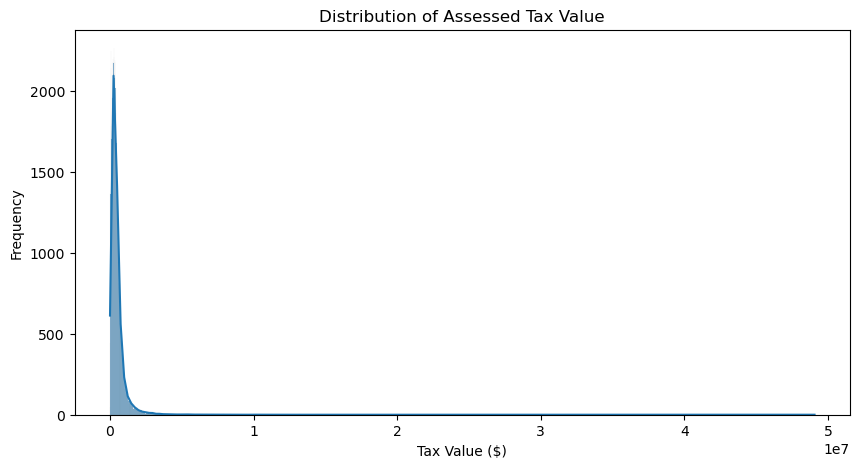

In [13]:
# Visualize the target variable 'taxvaluedollarcnt'
print(" Visualizing the distribution of the target variable 'taxvaluedollarcnt':")

plt.figure(figsize=(10,5))
sns.histplot(df['taxvaluedollarcnt'].dropna(), kde=True)
plt.title('Distribution of Assessed Tax Value')
plt.xlabel('Tax Value ($)')
plt.ylabel('Frequency')
plt.show()


2.A Discussion Summary

We loaded the Zillow dataset with 55 features and 77,613 rows. The target variable "taxvaluedollarcnt" has a right-skewed distribution, with values ranging from 100 dollors to 49 million,  indicating potential outliers that may need special treatment during modeling.

Based on our preliminary exploration, we categorized columns as follows:

Likely Useful:
Features logically affecting property value, such as bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, lotsizesquarefeet, latitude, and longitude.

Not useful (ID):
Features like parcelid are unique identifiers with no predictive value.

Less predictive (Uniform):  
Columns with only one unique value, such as decktypeid, hashottuborspa, poolcnt, and assessmentyear, providing no variance.

Target:  
taxvaluedollarcnt is our regression target variable.

Potentially Useful (Review):  
Features needing further review to assess their predictive power, such as buildingqualitytypeid, regionidcity, and propertylandusetypeid.

2.A.1: Which features are categorical?

Based on the dataset dtypes, the following features are categorical (dtype = object) and will require encoding before modeling:
- hashottuborspa
- propertycountylandusecode
- propertyzoningdesc
- fireplaceflag
- taxdelinquencyflag


2.A.2: Are there any features which appear at first glance to be useless for the business purpose of this project and should be deleted?

Yes. "parcelid" is an example of a feature that is useless for the business purpose of predicting tax value. It is a unique identifier that does not describe any physical, structural, or locational attribute of the property. Additionally, features like "taxdelinquencyflag" and "taxdelinquencyyear" relate to payment status rather than property characteristics, making them irrelevant for modeling assessed property value.


2.A.3: Are there any features which appear to be useless because of the percentage of missing values?

Yes. Features with more than 95% missing values are impractical to use. For example, "basementsqft" has ~99.9% missing values. Such extreme sparsity makes imputation unreliable and provides insufficient data coverage for meaningful modeling.

Key features with high missing values (>95%) include:
- basementsqft
- buildingclasstypeid
- architecturalstyletypeid
- finishedsquarefeet13
- yardbuildingsqft26
- (among others)

These will need to be addressed in Part 3 data cleaning.


2.A.4: Are there any features which appear to be useless because of the number of unique values?

Yes. Features with only one unique value across all rows provide no variance and are therefore useless for modeling. Examples include decktypeid, hashottuborspa, poolcnt, assessmentyear, and taxdelinquencyflag, each having a single value in the entire dataset.

 Generating histograms for all features to inspect their distributions:


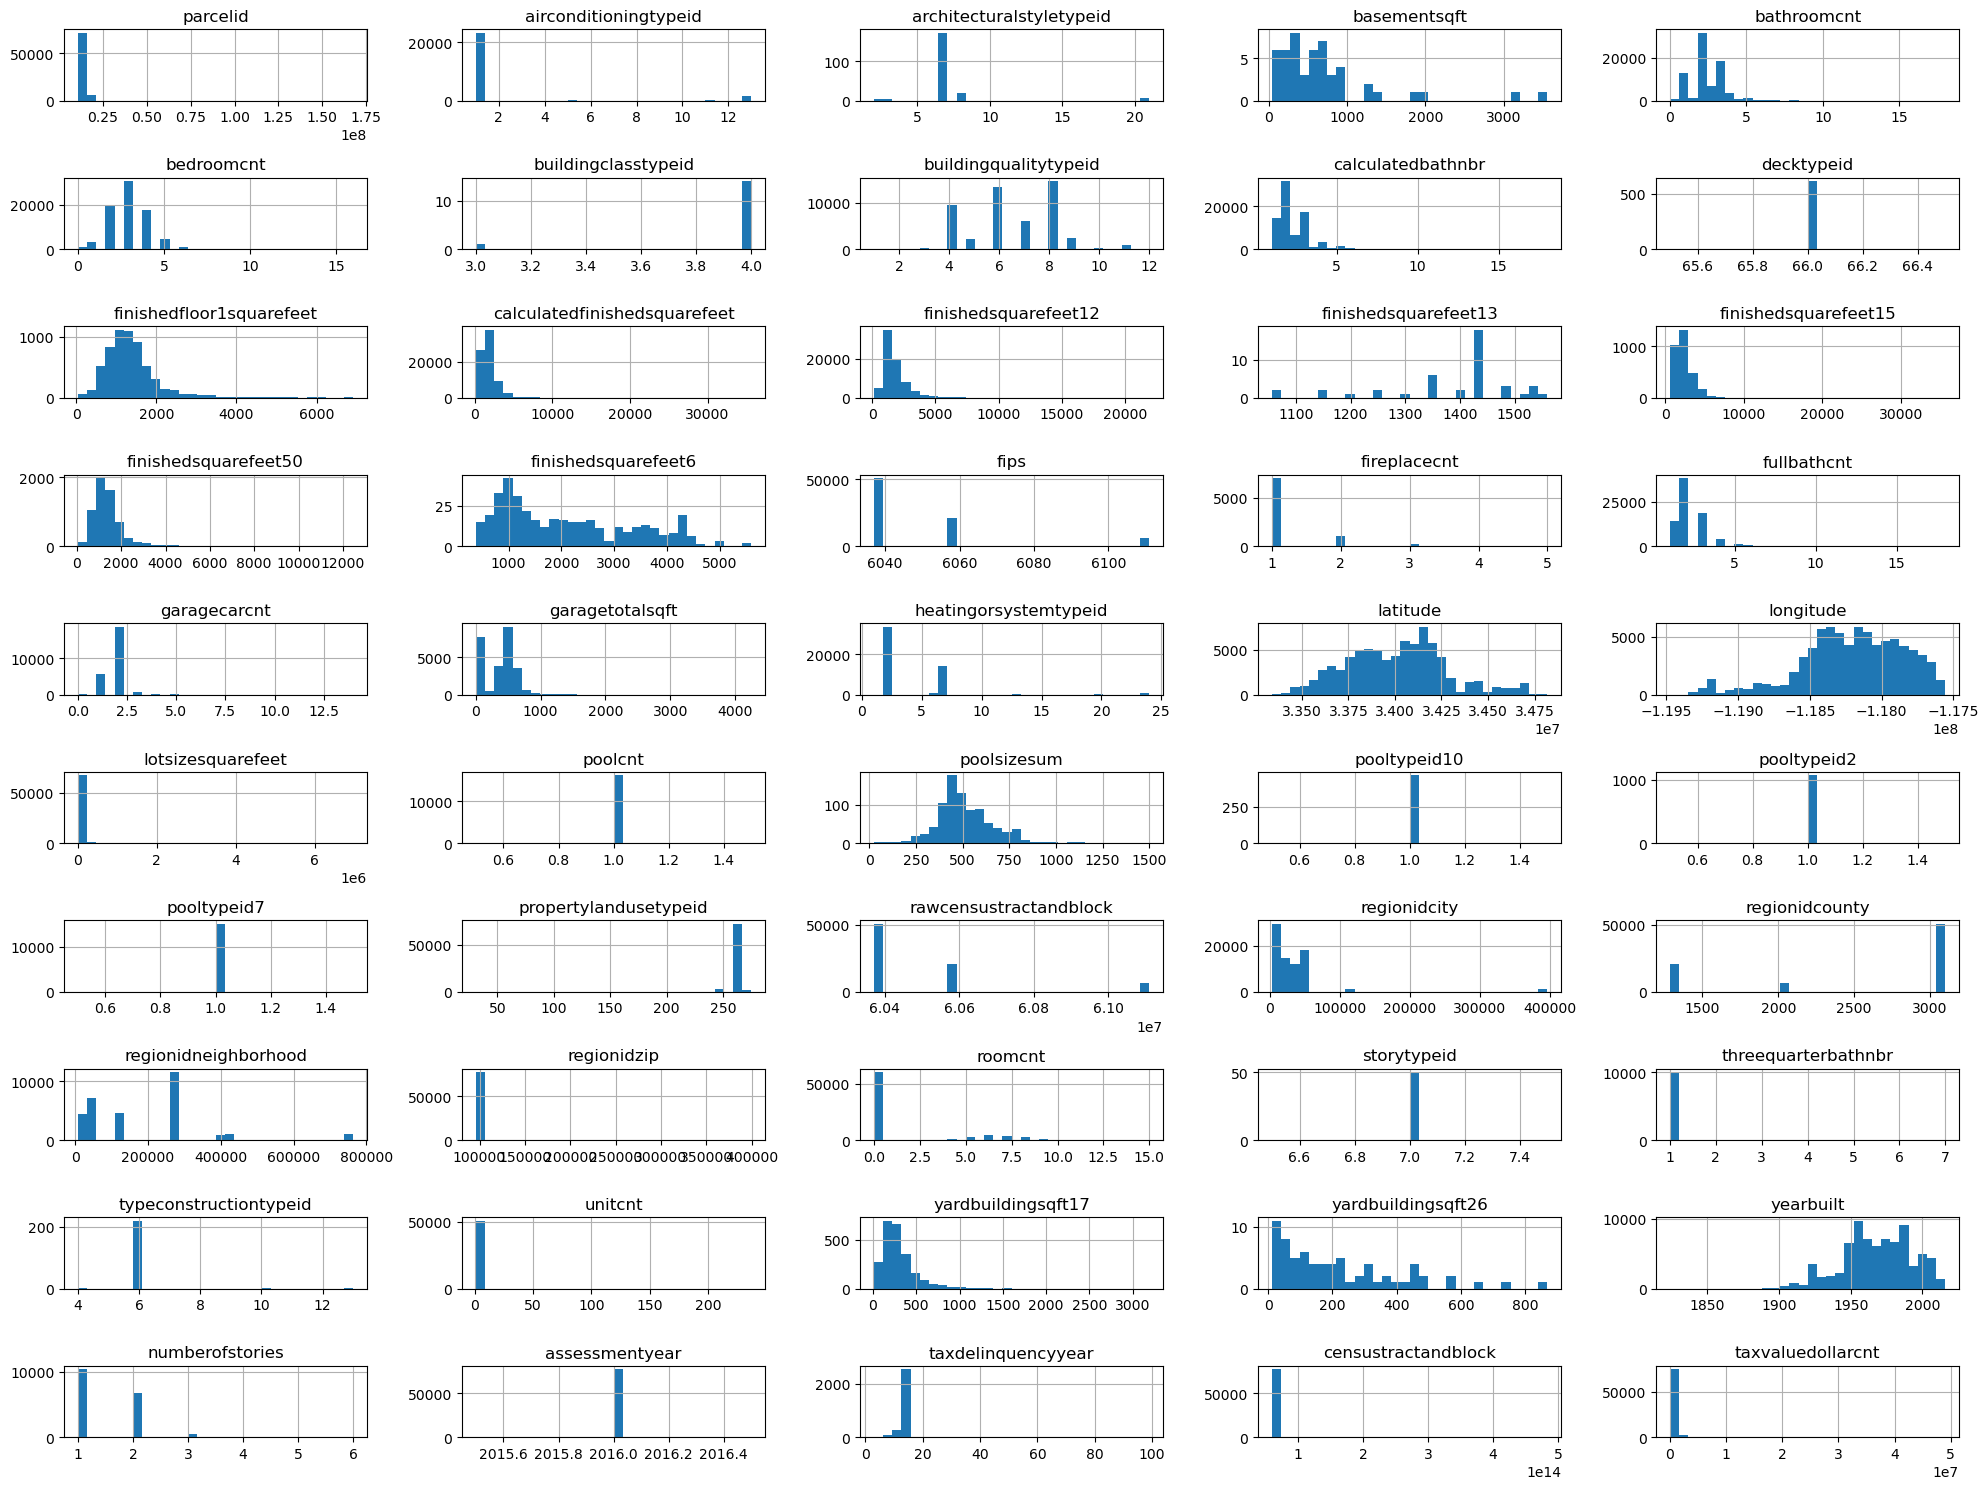

In [14]:
# =============================
# Part 2.B Step 1: Overview Histograms for All Features
# =============================
print(" Generating histograms for all features to inspect their distributions:")

df.hist(figsize=(20, 15), layout=(-1, 5), bins=30)
plt.tight_layout()
plt.show()


 Visualizing 'taxvaluedollarcnt' (target variable) distribution:


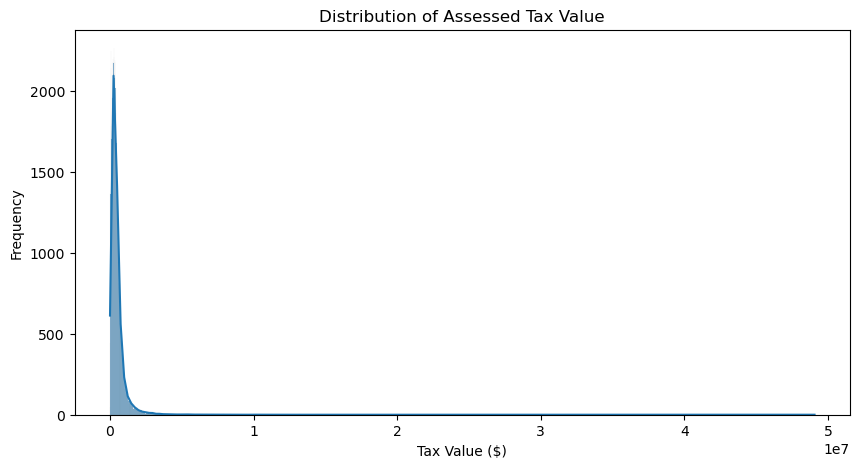

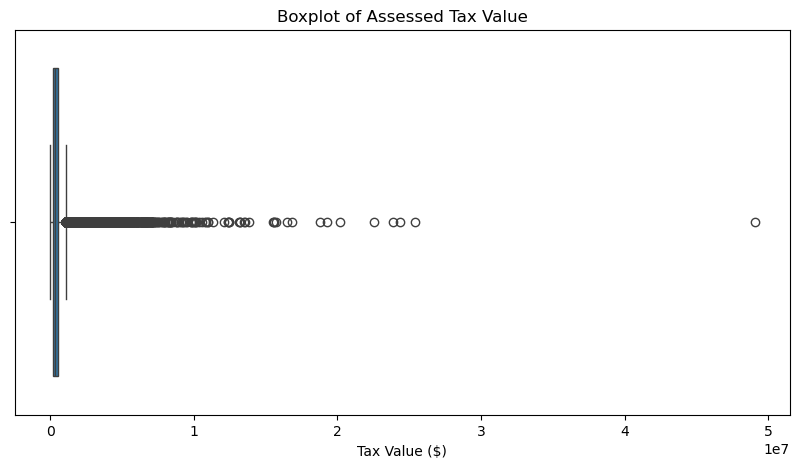

In [15]:
# =============================
# Part 2.B Step 2: Target Variable Visualization
# =============================
print(" Visualizing 'taxvaluedollarcnt' (target variable) distribution:")

plt.figure(figsize=(10,5))
sns.histplot(df['taxvaluedollarcnt'].dropna(), kde=True)
plt.title('Distribution of Assessed Tax Value')
plt.xlabel('Tax Value ($)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x=df['taxvaluedollarcnt'])
plt.title('Boxplot of Assessed Tax Value')
plt.xlabel('Tax Value ($)')
plt.show()


Part 2.B: Exploratory Data Analysis (EDA) – Feature-Level Visualization

Target Variable: "taxvaluedollarcnt" (Assessed Tax Value)

Plot Type: Histogram with KDE & Boxplot
Observation: The distribution is strongly right-skewed, with values ranging from 100 USD to 49 million USD. Most properties are valued below 1 million USD, while extreme outliers exist up to 49 million USD.

Implication: Potential need for log transformation or outlier treatment to normalize the distribution and improve model performance.

 Visualizing 'calculatedfinishedsquarefeet' (finished living area sq ft):


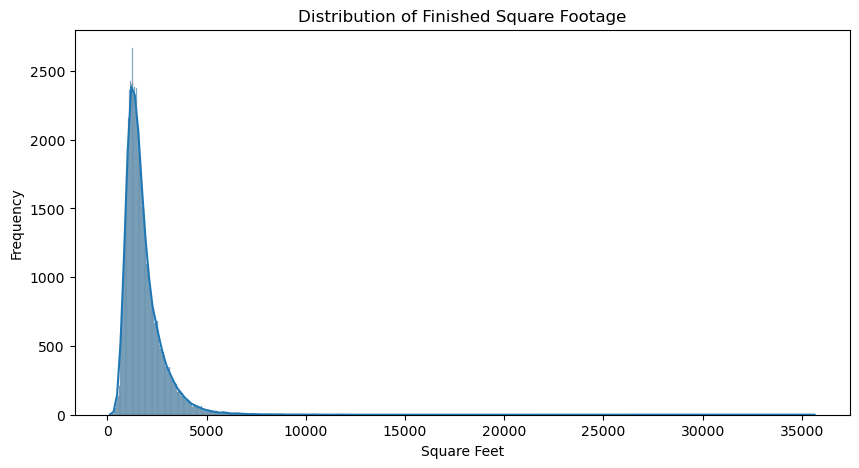

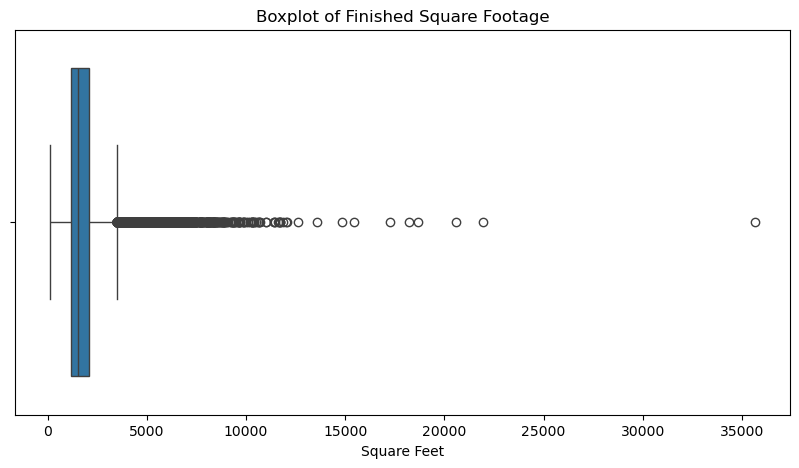

In [16]:
# =============================
# Part 2.B Step 3: Feature 1 - Finished Square Feet
# =============================
print(" Visualizing 'calculatedfinishedsquarefeet' (finished living area sq ft):")

plt.figure(figsize=(10,5))
sns.histplot(df['calculatedfinishedsquarefeet'].dropna(), kde=True)
plt.title('Distribution of Finished Square Footage')
plt.xlabel('Square Feet')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x=df['calculatedfinishedsquarefeet'])
plt.title('Boxplot of Finished Square Footage')
plt.xlabel('Square Feet')
plt.show()


Feature 1: "calculatedfinishedsquarefeet" (Finished Living Area Sqft)

Plot Type: Histogram with KDE & Boxplot
Observation: The distribution is right-skewed, with most properties between 1,000 – 2,500 sqft, and outliers above 10,000 sqft, indicating luxury homes.
Implication:Larger finished square footage likely correlates with higher tax value, but extreme outliers could skew regression results.


 Visualizing 'bathroomcnt' (number of bathrooms):


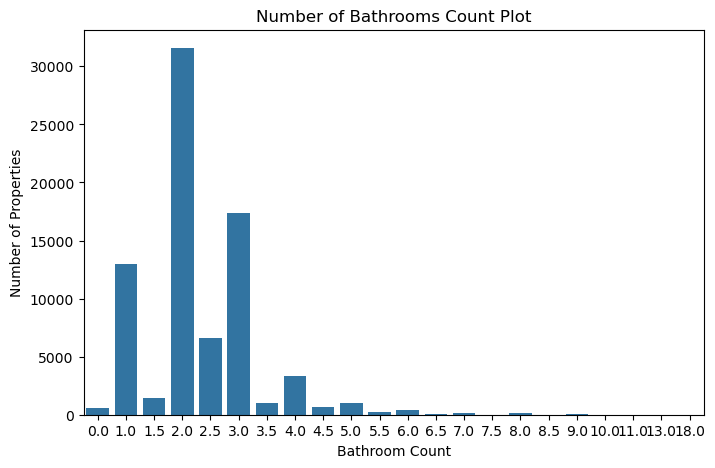

In [17]:
# =============================
# Part 2.B Step 4: Feature 2 - Bathroom Count
# =============================
print(" Visualizing 'bathroomcnt' (number of bathrooms):")

plt.figure(figsize=(8,5))
sns.countplot(x='bathroomcnt', data=df)
plt.title('Number of Bathrooms Count Plot')
plt.xlabel('Bathroom Count')
plt.ylabel('Number of Properties')
plt.show()


 Feature 2: "bathroomcnt" (Number of Bathrooms)

Plot Type: Countplot
Observation: Discrete distribution peaking at 2-3 bathrooms; very few properties have >5 bathrooms, suggesting potential data entry anomalies or luxury listings.
Implication: Number of bathrooms is a critical categorical predictor for property value models.


 Visualizing 'yearbuilt' (year the property was built):


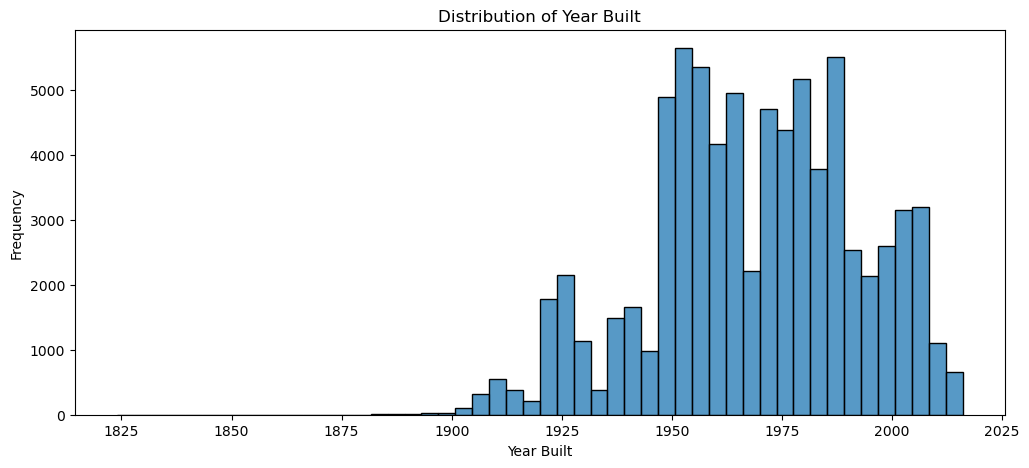

In [18]:
# =============================
# Part 2.B Step 5: Feature 3 - Year Built
# =============================
print(" Visualizing 'yearbuilt' (year the property was built):")

plt.figure(figsize=(12,5))
sns.histplot(df['yearbuilt'].dropna(), bins=50, kde=False)
plt.title('Distribution of Year Built')
plt.xlabel('Year Built')
plt.ylabel('Frequency')
plt.show()


Feature 3: "yearbuilt" (Year Built)

Plot Type: Histogram
Observation: The distribution is multi-modal, with peaks between 1950 – 1980, indicating many mid-century properties. Few were built post-2000 or before 1900.
Implication:Property age affects assessed tax value due to depreciation and construction standards.

Summary:

In examining these features:

All displayed*right-skewed or multi-modal distributions.
Outliers in "taxvaluedollarcnt" and "calculatedfinishedsquarefeet" may need treatment.
These features are key determinants of property value, showing patterns and distributions crucial for robust regression modeling.


Part 2.B Discussion

In our detailed examination, we observed that the target variable "taxvaluedollarcnt" has a strongly right-skewed (exponential-like) distribution, with most properties valued under 500,000 USD, but significant outliers exceeding 2 million USD, suggesting a need for log transformation to improve model performance. "calculatedfinishedsquarefeet" also showed a right-skewed distribution, with most homes between 1,000-2,500 sqft, but outliers above 10,000 sqft, indicating luxury properties that may disproportionately influence regression results if not handled appropriately. The "bathroomcnt" feature displayed a discrete distribution, peaking at 1-3 bathrooms, with very few properties having more than 5, which may reflect luxury homes or data inconsistencies worth checking. Finally, "yearbuilt" had a roughly uniform distribution with peaks between 1950-1980, suggesting many properties are mid-century builds, which may affect tax valuation due to age-related depreciation. We chose these features because they are fundamental determinants of property value, and their distributions revealed interesting patterns, outliers, and potential modeling challenges critical for developing an effective regression solution.

In [19]:
# =============================
# Part 3.A: Drop Unsuitable Features for Regression Task
# =============================

# Define a function to drop specified columns
def drop_columns(df, cols_to_drop):
    """
    Drops specified columns from the dataframe.
    
    Parameters:
    df : pandas DataFrame
        Input dataframe.
    cols_to_drop : list
        List of column names to drop.
    
    Returns:
    df_dropped : pandas DataFrame
        Dataframe after dropping specified columns.
    """
    df_dropped = df.drop(columns=cols_to_drop)
    return df_dropped

# Based on Appendix 1 and domain logic, define unsuitable columns
# (excluding missingness-based drops for this step)
unsuitable_cols = [
    'parcelid',                 # Unique property ID
    'rawcensustractandblock',   # Unprocessed census block ID
    'censustractandblock',      # Combined census tract/block ID
    'assessmentyear',           # Likely constant in dataset snapshot
    'taxdelinquencyflag',       # Payment status, not predictive of value
    'taxdelinquencyyear'        # Year taxes became delinquent (payment status)
]

# Print features to be dropped
print(" Features judged unsuitable for regression (dropping in Part 3.A):")
print(unsuitable_cols)

# Apply drop_columns function to drop unsuitable features
df_part3A_dropped = drop_columns(df, unsuitable_cols)

# Check shape after dropping
print(" Shape after dropping unsuitable features:", df_part3A_dropped.shape)

# Preview the resulting dataframe
df_part3A_dropped.head()


 Features judged unsuitable for regression (dropping in Part 3.A):
['parcelid', 'rawcensustractandblock', 'censustractandblock', 'assessmentyear', 'taxdelinquencyflag', 'taxdelinquencyyear']
 Shape after dropping unsuitable features: (77613, 49)


,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,...,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,taxvaluedollarcnt
0,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,1023282.0
1,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,464000.0
2,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,564778.0
3,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,145143.0
4,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,119407.0


Part 3.A: Dropping Unsuitable Features (Not Based on Missingness)

We have dropped features that are unsuitable for regression prediction, including:

ID-like columns: e.g. "parcelid", which provides no predictive value.
Unprocessed or purely geographic identifiers: e.g. "rawcensustractandblock", "censustractandblock", without mapping interpretation.
Payment-related columns: "taxdelinquencyflag", "taxdelinquencyyear", which reflect payment status rather than property characteristics.
Likely constant column: "assessmentyear", providing no useful variance.

This prepares the dataset by retaining only features relevant to property value prediction.

3.A Discussion

In this step, we dropped features deemed unsuitable for the regression task based on domain understanding and dataset characteristics. Specifically, we removed "parcelid", which functions as an identifier column with no predictive power. We also dropped "rawcensustractandblock" and "censustractandblock", as they are unprocessed or combined geographic codes without direct interpretability for property tax value prediction. Additionally, "assessmentyear" was dropped because it is constant in this dataset snapshot, providing no variance for modeling. Finally, "taxdelinquencyflag" and "taxdelinquencyyear" were dropped because they reflect payment status rather than property characteristics and thus are not useful for predicting assessed tax value. Removing these features ensures our dataset retains only columns with meaningful predictive information.

In [20]:
# =============================
# Part 3.B: Drop Features with "Too Many" Null Values
# =============================

# Calculate % missing values per column
missing_perc = df_part3A_dropped.isnull().mean() * 100

# Display summary for careful review
print("Missing value percentages for each feature: \n")
display(missing_perc.sort_values(ascending=False))


# Define threshold for "too many" missing values
missing_threshold = 70.0  # Adjust if your dataset warrants a different cutoff

# List features exceeding the threshold
high_missing_cols = missing_perc[missing_perc > missing_threshold].index.tolist()

print(f" \n Features with > {missing_threshold}%  missing values:")
print(high_missing_cols)


# Drop high-missingness features
df_part3B_dropped = drop_columns(df_part3A_dropped, high_missing_cols)

# Check resulting dataframe shape
print(" \n Shape after dropping high-missingness features: \n", df_part3B_dropped.shape)

# Preview cleaned dataframe
df_part3B_dropped.head()


Missing value percentages for each feature: 



buildingclasstypeid             99.980673
finishedsquarefeet13            99.945885
basementsqft                    99.935578
storytypeid                     99.935578
yardbuildingsqft26              99.909809
fireplaceflag                   99.778388
architecturalstyletypeid        99.733292
typeconstructiontypeid          99.712677
finishedsquarefeet6             99.502661
pooltypeid10                    99.400874
decktypeid                      99.208895
poolsizesum                     98.880342
pooltypeid2                     98.616211
hashottuborspa                  98.017085
yardbuildingsqft17              96.916754
finishedsquarefeet15            96.099880
finishedsquarefeet50            92.221664
finishedfloor1squarefeet        92.221664
fireplacecnt                    89.320088
threequarterbathnbr             86.978985
pooltypeid7                     80.571554
poolcnt                         79.160708
numberofstories                 77.324675
airconditioningtypeid           67

 
 Features with > 70.0%  missing values:
['architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'hashottuborspa', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26', 'numberofstories', 'fireplaceflag']
 
 Shape after dropping high-missingness features: 
 (77613, 26)


,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,garagecarcnt,...,propertylandusetypeid,propertyzoningdesc,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,unitcnt,yearbuilt,taxvaluedollarcnt
0,NaN,3.5,4.0,NaN,3.5,3100.0,3100.0,6059.0,3.0,2.0,...,261.0,NaN,53571.0,1286.0,NaN,96978.0,0.0,NaN,1998.0,1023282.0
1,NaN,1.0,2.0,NaN,1.0,1465.0,1465.0,6111.0,1.0,1.0,...,261.0,NaN,13091.0,2061.0,NaN,97099.0,5.0,NaN,1967.0,464000.0
2,NaN,2.0,3.0,NaN,2.0,1243.0,1243.0,6059.0,2.0,2.0,...,261.0,NaN,21412.0,1286.0,NaN,97078.0,6.0,NaN,1962.0,564778.0
3,NaN,3.0,4.0,8.0,3.0,2376.0,2376.0,6037.0,3.0,NaN,...,261.0,LCR110000*,396551.0,3101.0,NaN,96330.0,0.0,1.0,1970.0,145143.0
4,1.0,3.0,3.0,8.0,3.0,1312.0,1312.0,6037.0,3.0,NaN,...,266.0,LAR3,12447.0,3101.0,268548.0,96451.0,0.0,1.0,1964.0,119407.0


3.B Discussion

In this step, we dropped features that had more than 70% missing values, as such features provide limited usable information for training, and imputing them would introduce excessive assumptions or noise. After reviewing the missingness summary, we found that columns like "architecturalstyletypeid", "decktypeid", "finishedsquarefeet13", "finishedsquarefeet15", and several pool- and yard-related features exceeded this threshold. While "too many" is subjective, we selected 70% because it retains the majority of features with sufficient data coverage while removing those with inadequate sample sizes for reliable modeling. Dropping these features simplifies the dataset, reduces potential imputation bias, and ensures cleaner, more robust data for downstream regression analysis.

In [21]:
# =============================
# Part 3.C: Drop Problematic Samples
# =============================

# Check initial shape
print("Initial shape before dropping problematic samples:", df_part3B_dropped.shape)

# 1. Drop samples with missing target value
df_part3C_dropped = df_part3B_dropped[df_part3B_dropped['taxvaluedollarcnt'].notnull()]
print("\n Shape after dropping rows with missing target:", df_part3C_dropped.shape)

# 2. Drop samples with "too many" null values across features (define threshold, e.g. >50% missing)
row_missing_perc = df_part3C_dropped.isnull().mean(axis=1) * 100
too_many_missing_rows = df_part3C_dropped[row_missing_perc > 50].index.tolist()
print(f" \n Number of rows with >50% missing features: {len(too_many_missing_rows)}")

# Drop these rows
df_part3C_dropped = df_part3C_dropped.drop(index=too_many_missing_rows)
print("\n Shape after dropping rows with >50% missing features:", df_part3C_dropped.shape)

# 3. Optional outlier removal in target (e.g. removing values above 99th percentile for modeling stability)
target_99pct = df_part3C_dropped['taxvaluedollarcnt'].quantile(0.99)
df_part3C_dropped = df_part3C_dropped[df_part3C_dropped['taxvaluedollarcnt'] <= target_99pct]
print("\n Shape after removing top 1% outliers in target:", df_part3C_dropped.shape)

# Preview cleaned dataset
df_part3C_dropped.head()


Initial shape before dropping problematic samples: (77613, 26)

 Shape after dropping rows with missing target: (77578, 26)
 
 Number of rows with >50% missing features: 51

 Shape after dropping rows with >50% missing features: (77527, 26)

 Shape after removing top 1% outliers in target: (76751, 26)


,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,garagecarcnt,...,propertylandusetypeid,propertyzoningdesc,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,unitcnt,yearbuilt,taxvaluedollarcnt
0,NaN,3.5,4.0,NaN,3.5,3100.0,3100.0,6059.0,3.0,2.0,...,261.0,NaN,53571.0,1286.0,NaN,96978.0,0.0,NaN,1998.0,1023282.0
1,NaN,1.0,2.0,NaN,1.0,1465.0,1465.0,6111.0,1.0,1.0,...,261.0,NaN,13091.0,2061.0,NaN,97099.0,5.0,NaN,1967.0,464000.0
2,NaN,2.0,3.0,NaN,2.0,1243.0,1243.0,6059.0,2.0,2.0,...,261.0,NaN,21412.0,1286.0,NaN,97078.0,6.0,NaN,1962.0,564778.0
3,NaN,3.0,4.0,8.0,3.0,2376.0,2376.0,6037.0,3.0,NaN,...,261.0,LCR110000*,396551.0,3101.0,NaN,96330.0,0.0,1.0,1970.0,145143.0
4,1.0,3.0,3.0,8.0,3.0,1312.0,1312.0,6037.0,3.0,NaN,...,266.0,LAR3,12447.0,3101.0,268548.0,96451.0,0.0,1.0,1964.0,119407.0


### 3.C Discussion

In this step, we dropped samples that were unsuitable for modeling. First, we removed rows with missing target values (taxvaluedollarcnt), as they cannot be used for supervised regression. Next, we dropped samples with more than 50% missing feature values, since imputing these would introduce excessive assumptions and reduce data reliability. Finally, we removed the top 1% of extreme outliers in the target variable, as these luxury property values could disproportionately skew model training and reduce predictive performance on typical properties. These decisions ensure that the dataset remains clean, complete, and representative for accurate and robust regression analysis.

In [22]:
# =============================
# Part 3.D: Impute for Remaining Missing Values
# =============================

# Function to impute missing values
def impute_missing(df):
    """
    Imputes missing values:
    - Numerical features: median
    - Categorical features: mode
    
    Returns a new dataframe with imputed values.
    """
    df_imputed = df.copy()
    
    # Separate numerical and categorical columns
    num_cols = df_imputed.select_dtypes(include=[np.number]).columns
    cat_cols = df_imputed.select_dtypes(include=['object']).columns
    
    # Impute numerical columns with median (robust to outliers and skewness)
    num_imputer = SimpleImputer(strategy='median')
    df_imputed[num_cols] = num_imputer.fit_transform(df_imputed[num_cols])
    
    # Impute categorical columns with mode (most frequent category)
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df_imputed[cat_cols] = cat_imputer.fit_transform(df_imputed[cat_cols])
    
    return df_imputed

# Apply the imputation function to Part 3.C cleaned dataset
df_part3D_imputed = impute_missing(df_part3C_dropped)

# Check that no missing values remain
print(" Total remaining missing values after imputation:", df_part3D_imputed.isnull().sum().sum())

# Preview the final imputed dataset
df_part3D_imputed.head()


 Total remaining missing values after imputation: 0


,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,garagecarcnt,...,propertylandusetypeid,propertyzoningdesc,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,unitcnt,yearbuilt,taxvaluedollarcnt
0,1.0,3.5,4.0,6.0,3.5,3100.0,3100.0,6059.0,3.0,2.0,...,261.0,LAR1,53571.0,1286.0,118849.0,96978.0,0.0,1.0,1998.0,1023282.0
1,1.0,1.0,2.0,6.0,1.0,1465.0,1465.0,6111.0,1.0,1.0,...,261.0,LAR1,13091.0,2061.0,118849.0,97099.0,5.0,1.0,1967.0,464000.0
2,1.0,2.0,3.0,6.0,2.0,1243.0,1243.0,6059.0,2.0,2.0,...,261.0,LAR1,21412.0,1286.0,118849.0,97078.0,6.0,1.0,1962.0,564778.0
3,1.0,3.0,4.0,8.0,3.0,2376.0,2376.0,6037.0,3.0,2.0,...,261.0,LCR110000*,396551.0,3101.0,118849.0,96330.0,0.0,1.0,1970.0,145143.0
4,1.0,3.0,3.0,8.0,3.0,1312.0,1312.0,6037.0,3.0,2.0,...,266.0,LAR3,12447.0,3101.0,268548.0,96451.0,0.0,1.0,1964.0,119407.0


3.D Discussion (Extended with Appendix 2 Justification)

Based on the Appendix 2 imputation guidelines, we applied median imputation for numerical features, as many property-related numerical variables (e.g. square footage, room counts) are right-skewed, and the median is robust to outliers while preserving the integrity of their distributions. For categorical features, we used mode imputation, replacing missing values with the most frequent category to maintain the existing class distribution without introducing artificial categories. Although advanced methods such as KNN or MICE could capture complex inter-feature relationships, they are computationally intensive and unnecessary at this stage. These imputation choices align with best practices for structured datasets with mixed data types, ensuring that no null values remain while preserving data quality, interpretability, and readiness for downstream regression modeling.

In [23]:
# =============================
# Part 3.E: Encode Categorical Features (if any)
# =============================

# Function to encode categorical features
def encode_categorical(df):
    """
    Encodes categorical (object) features using OrdinalEncoder.
    
    Returns a new dataframe with encoded features.
    """
    df_encoded = df.copy()
    
    # Identify categorical columns
    cat_cols = df_encoded.select_dtypes(include=['object']).columns
    
    if len(cat_cols) > 0:
        encoder = OrdinalEncoder()
        df_encoded[cat_cols] = encoder.fit_transform(df_encoded[cat_cols])
        print(" Categorical features encoded:", list(cat_cols))
    else:
        print(" No categorical features to encode.")
    
    return df_encoded

# Apply the encoding function to the Part 3.D imputed dataset
df_part3E_encoded = encode_categorical(df_part3D_imputed)

# Preview final encoded dataset
df_part3E_encoded.head()


 Categorical features encoded: ['propertycountylandusecode', 'propertyzoningdesc']


,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,garagecarcnt,...,propertylandusetypeid,propertyzoningdesc,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,unitcnt,yearbuilt,taxvaluedollarcnt
0,1.0,3.5,4.0,6.0,3.5,3100.0,3100.0,6059.0,3.0,2.0,...,261.0,575.0,53571.0,1286.0,118849.0,96978.0,0.0,1.0,1998.0,1023282.0
1,1.0,1.0,2.0,6.0,1.0,1465.0,1465.0,6111.0,1.0,1.0,...,261.0,575.0,13091.0,2061.0,118849.0,97099.0,5.0,1.0,1967.0,464000.0
2,1.0,2.0,3.0,6.0,2.0,1243.0,1243.0,6059.0,2.0,2.0,...,261.0,575.0,21412.0,1286.0,118849.0,97078.0,6.0,1.0,1962.0,564778.0
3,1.0,3.0,4.0,8.0,3.0,2376.0,2376.0,6037.0,3.0,2.0,...,261.0,788.0,396551.0,3101.0,118849.0,96330.0,0.0,1.0,1970.0,145143.0
4,1.0,3.0,3.0,8.0,3.0,1312.0,1312.0,6037.0,3.0,2.0,...,266.0,582.0,12447.0,3101.0,268548.0,96451.0,0.0,1.0,1964.0,119407.0


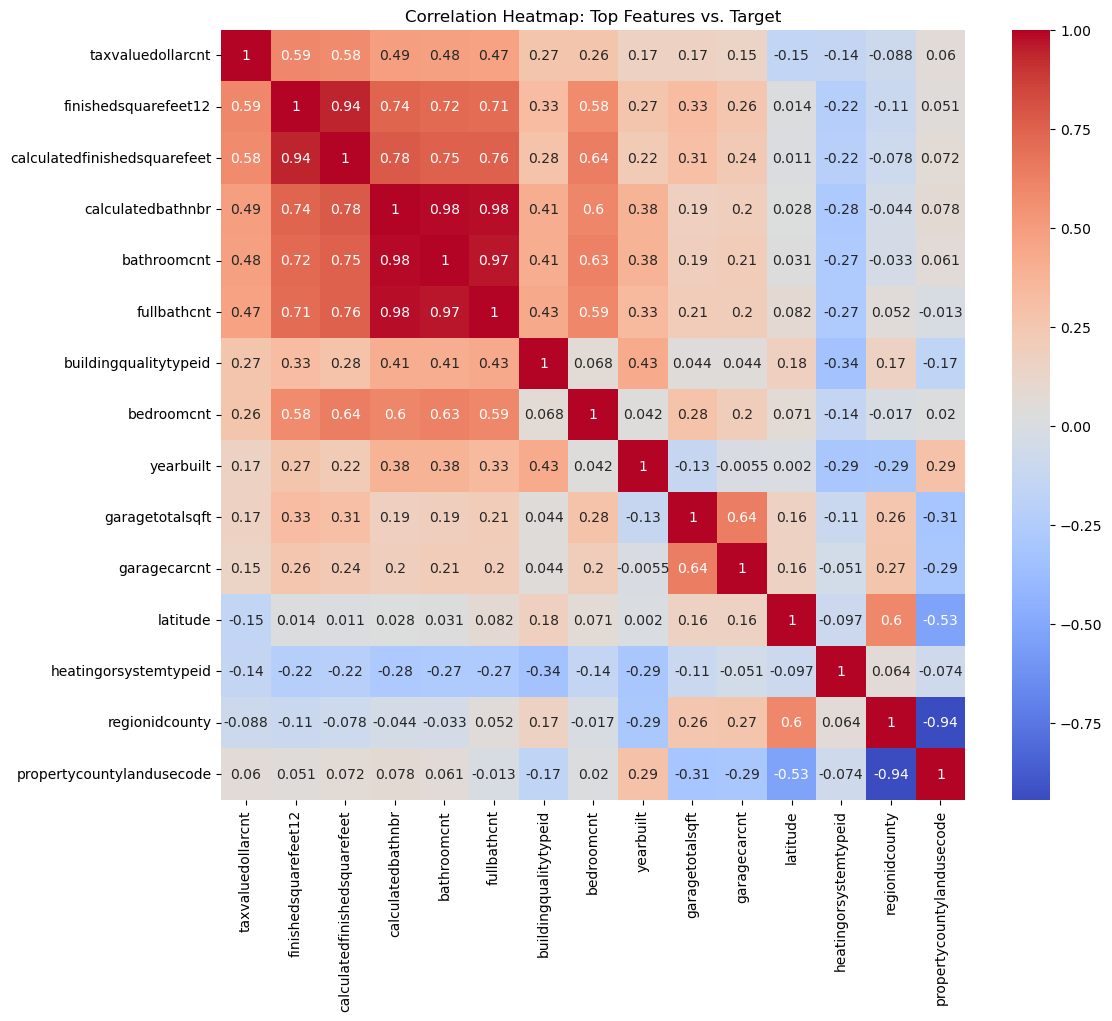

Top 10 correlations with target:
taxvaluedollarcnt               1.000000
finishedsquarefeet12            0.590873
calculatedfinishedsquarefeet    0.578124
calculatedbathnbr               0.490176
bathroomcnt                     0.477040
fullbathcnt                     0.468657
buildingqualitytypeid           0.265669
bedroomcnt                      0.263804
yearbuilt                       0.171201
garagetotalsqft                 0.168407
Name: taxvaluedollarcnt, dtype: float64


In [24]:
# =============================
# Part 4.A Step 1: Compute and Visualize Correlation Matrix
# =============================

# Calculate correlation matrix
corr_matrix = df_part3E_encoded.corr()

# Plot heatmap for top 15 features most correlated with target
plt.figure(figsize=(12,10))
top_corr_features = corr_matrix['taxvaluedollarcnt'].abs().sort_values(ascending=False).head(15).index
sns.heatmap(df_part3E_encoded[top_corr_features].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap: Top Features vs. Target")
plt.show()

# Display top correlations with the target
target_corr = corr_matrix['taxvaluedollarcnt'].sort_values(ascending=False)
print("Top 10 correlations with target:")
print(target_corr.head(10))



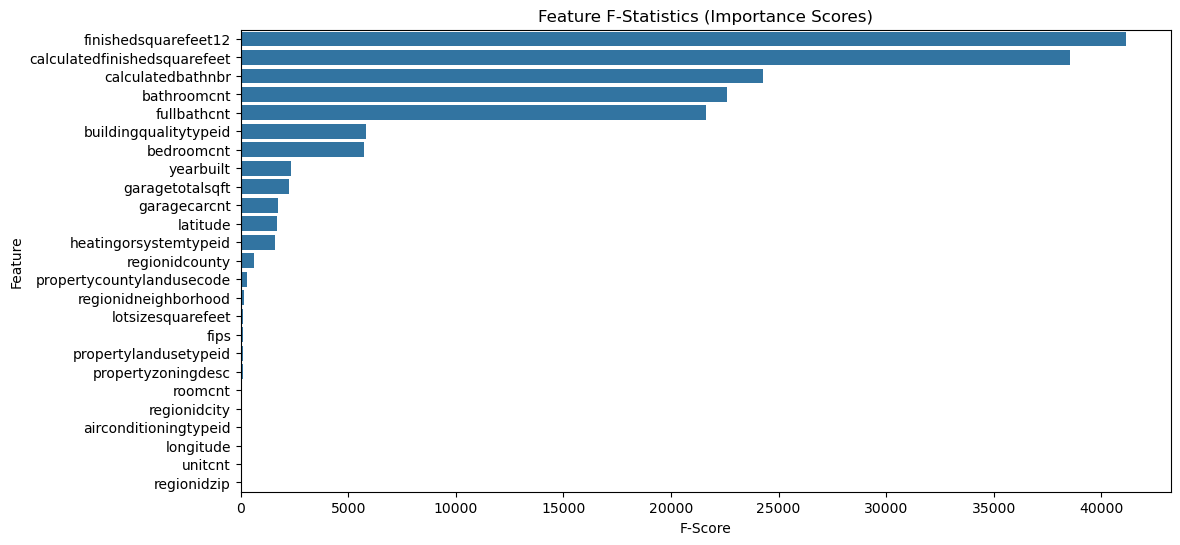

,Feature,F-Score,p-Value
6,finishedsquarefeet12,41168.826195,0.0
5,calculatedfinishedsquarefeet,38529.036083,0.0
4,calculatedbathnbr,24272.744581,0.0
1,bathroomcnt,22611.097453,0.0
8,fullbathcnt,21601.651106,0.0
3,buildingqualitytypeid,5828.291900,0.0
2,bedroomcnt,5740.648339,0.0
24,yearbuilt,2317.423026,0.0
10,garagetotalsqft,2240.193929,0.0
9,garagecarcnt,1717.067696,0.0


In [25]:
# =============================
# Part 4.A Step 2: Compute F-statistics for Feature Importance
# =============================

# Separate features and target
X = df_part3E_encoded.drop(columns=['taxvaluedollarcnt'])
y = df_part3E_encoded['taxvaluedollarcnt']

# Calculate F-statistics and p-values
f_scores, p_values = f_regression(X, y)

# Create DataFrame for visualization
f_stats_df = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': f_scores,
    'p-Value': p_values
}).sort_values(by='F-Score', ascending=False)

# Plot F-statistics as a bar chart
plt.figure(figsize=(12,6))
sns.barplot(x='F-Score', y='Feature', data=f_stats_df)
plt.title('Feature F-Statistics (Importance Scores)')
plt.xlabel('F-Score')
plt.ylabel('Feature')
plt.show()

# Display top features based on F-score
f_stats_df.head(10)


In [26]:
# =============================
# Part 4.A Step 3: Forward and Backward Feature Selection using LinerRegression
# =============================

from sklearn.linear_model import LinearRegression
# Initialize base model
model = LinearRegression()

# Forward selection
sfs_forward = SequentialFeatureSelector(model, n_features_to_select=5, direction='forward')
sfs_forward.fit(X, y)
print(" Features selected by forward selection:", X.columns[sfs_forward.get_support()].tolist())

# Backward selection
sfs_backward = SequentialFeatureSelector(model, n_features_to_select=5, direction='backward')
sfs_backward.fit(X, y)
print(" Features selected by backward selection:", X.columns[sfs_backward.get_support()].tolist())


 Features selected by forward selection: ['buildingqualitytypeid', 'finishedsquarefeet12', 'latitude', 'longitude', 'roomcnt']
 Features selected by backward selection: ['bathroomcnt', 'finishedsquarefeet12', 'latitude', 'longitude', 'roomcnt']


4.A Discussion

In this feature relationship investigation, the correlation matrix showed that finishedsquarefeet12 and calculatedfinishedsquarefeet are the most strongly correlated with the target variable taxvaluedollarcnt (correlations of approximately 0.59 and 0.58, respectively). Features such as calculatedbathnbr, bathroomcnt, and fullbathcnt also had moderate positive correlations (around 0.47–0.49), indicating their relevance to predicting property value. Interestingly, some features like latitude and heatingorsystemtypeid showed weak negative correlations, suggesting location or heating type might inversely relate to tax value in certain contexts.

The F-statistic bar chart confirmed these insights, with finishedsquarefeet12 and calculatedfinishedsquarefeet having the highest F-scores, reinforcing their predictive power. Features like buildingqualitytypeid and bedroomcnt showed lower F-statistics, indicating weaker individual contributions.

For feature selection, both forward and backward selection methods consistently chose finishedsquarefeet12, latitude, longitude, and roomcnt, suggesting strong agreement on their importance. However, forward selection included buildingqualitytypeid, while backward selection preferred bathroomcnt, revealing slight differences based on algorithm directionality.

Overall, the different methods broadly agree on the importance of square footage and bathroom-related features for predicting property value, though minor differences indicate that final feature selection decisions should be model-specific and validated during Milestone 2 model development.

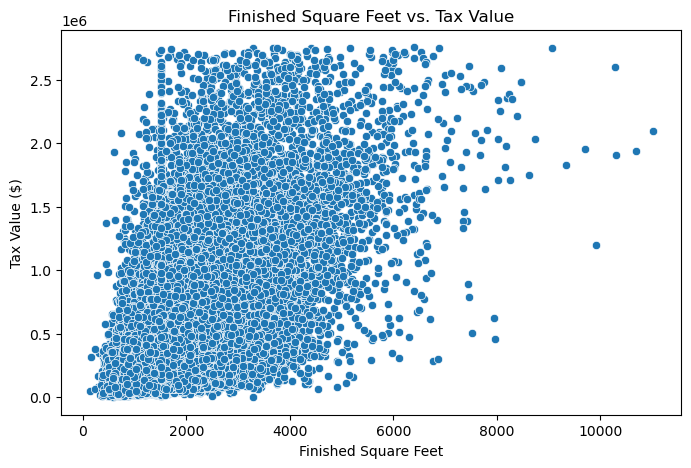

In [27]:
# Part 4.B: 2-Dimensional Visualizations for Interesting Patterns
# Pair 1: Finished Square Feet vs. Tax Value

plt.figure(figsize=(8,5))
sns.scatterplot(x='finishedsquarefeet12', y='taxvaluedollarcnt', data=df_part3E_encoded)
plt.title('Finished Square Feet vs. Tax Value')
plt.xlabel('Finished Square Feet')
plt.ylabel('Tax Value ($)')
plt.show()


This scatter plot shows a clear positive relationship between finished square footage and assessed tax value. As square footage increases, the tax value generally rises, indicating that larger properties are typically assessed at higher values. However, the spread becomes wider at higher square footage levels, suggesting greater variability in assessed values for larger homes. This could be due to differences in location, quality, or luxury features that add value beyond square footage alone. A few extreme outliers are visible, representing very large or high-value properties with assessments far above the general trend.

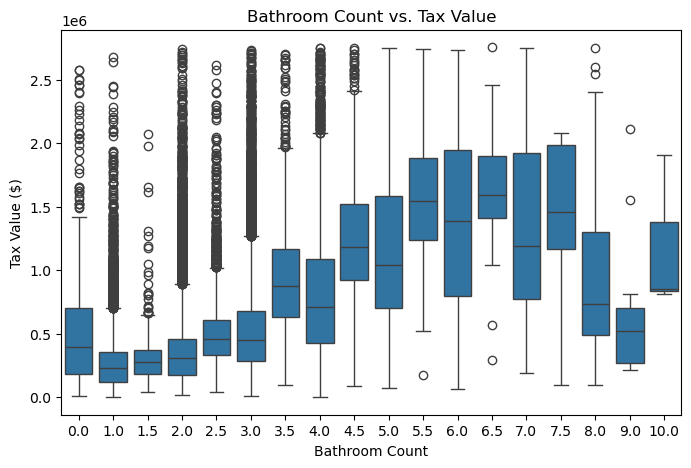

In [28]:
# Pair 2: Bathroom Count vs. Tax Value

plt.figure(figsize=(8,5))
sns.boxplot(x='bathroomcnt', y='taxvaluedollarcnt', data=df_part3E_encoded)
plt.title('Bathroom Count vs. Tax Value')
plt.xlabel('Bathroom Count')
plt.ylabel('Tax Value ($)')
plt.show()


The boxplot indicates that properties with a higher number of bathrooms generally have higher assessed tax values, reflecting the typical association between bathroom count and overall property size and luxury. However, extreme outliers are present across all bathroom counts, suggesting that some properties, regardless of the typical trend, have exceptionally high tax values due to luxury features, premium locations, or unique characteristics. The spread also increases with bathroom count, highlighting greater variability in assessed values among larger or more luxurious homes.

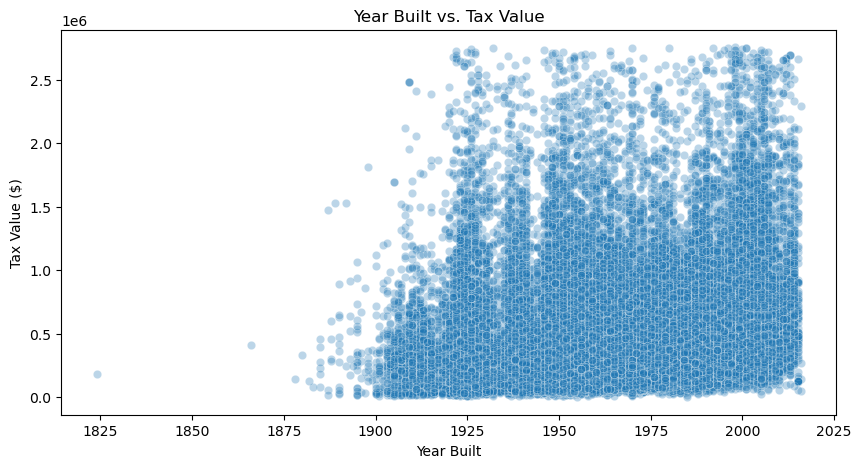

In [29]:
# Pair 3: Year Built vs. Tax Value

plt.figure(figsize=(10,5))
sns.scatterplot(x='yearbuilt', y='taxvaluedollarcnt', data=df_part3E_encoded, alpha=0.3)
plt.title('Year Built vs. Tax Value')
plt.xlabel('Year Built')
plt.ylabel('Tax Value ($)')
plt.show()

This scatter plot reveals that newer properties tend to have higher assessed tax values, likely due to modern construction standards, amenities, and neighborhood development. While older properties show a wide range of tax values, indicating that renovations or prime locations can maintain value, properties built after 2000 cluster more densely at higher tax values, reflecting general appreciation, modernization effects, and potentially larger or luxury builds in recent decades.

In [30]:
# Part 5: Feature Engineering – Transformations and Evaluations

# 5.A: Setup and Transformation Functions

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Copy dataset for feature engineering
df_part5 = df_part3E_encoded.copy()

# Separate features and target
X_part5 = df_part5.drop(columns=['taxvaluedollarcnt'])
y_part5 = df_part5['taxvaluedollarcnt']

# Function 1: Log Transformation of skewed numerical features
def add_log_transformation(df, cols):
    df_new = df.copy()
    for col in cols:
        df_new[col + '_log'] = np.log1p(df_new[col])  # log1p for stability on zero values
    return df_new

# Function 2: Polynomial Features (squared)
def add_polynomial_features(df, cols, degree=2):
    df_new = df.copy()
    for col in cols:
        df_new[col + f'_pow{degree}'] = df_new[col] ** degree
    return df_new

# Function 3: Feature Ratios
def add_ratio_feature(df, num_col, denom_col):
    df_new = df.copy()
    df_new[num_col + '_per_' + denom_col] = df_new[num_col] / (df_new[denom_col] + 1e-5)  # avoid division by zero
    return df_new

# Example features to transform
num_features = ['calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt']


In [31]:
# 5.B: Apply Transformations

# 1. Log transformation for finished square feet

X_log = add_log_transformation(X_part5, ['calculatedfinishedsquarefeet'])

# 2. Polynomial (squared) transformation for bathroom count
X_poly = add_polynomial_features(X_part5, ['bathroomcnt'])

# 3. Ratio feature: bathrooms per bedroom
X_ratio = add_ratio_feature(X_part5, 'bathroomcnt', 'bedroomcnt')


In [32]:
# 5.C: Evaluate Effects with F-Statistics

# Combine transformed features back to main dataframe for evaluation

X_transformed = pd.concat([X_part5, 
                           X_log[['calculatedfinishedsquarefeet_log']], 
                           X_poly[['bathroomcnt_pow2']], 
                           X_ratio[['bathroomcnt_per_bedroomcnt']]], axis=1)

# Calculate F-statistics
f_scores, p_values = f_regression(X_transformed.fillna(0), y_part5)

# Create results dataframe
f_results = pd.DataFrame({
    'Feature': X_transformed.columns,
    'F-Score': f_scores,
    'p-Value': p_values
}).sort_values(by='F-Score', ascending=False)

# Display top engineered features for quick interpretation
print(f_results.head(10))


                             Feature       F-Score  p-Value
6               finishedsquarefeet12  41168.826195      0.0
5       calculatedfinishedsquarefeet  38529.036083      0.0
25  calculatedfinishedsquarefeet_log  30858.079514      0.0
4                  calculatedbathnbr  24272.744581      0.0
26                  bathroomcnt_pow2  23850.151447      0.0
1                        bathroomcnt  22611.097453      0.0
8                        fullbathcnt  21601.651106      0.0
3              buildingqualitytypeid   5828.291900      0.0
2                         bedroomcnt   5740.648339      0.0
24                         yearbuilt   2317.423026      0.0


# 5.D Discussion – Feature Engineering Insights

In this investigation, we explored three transformations:

1. Log Transformation of "calculatedfinishedsquarefeet" reduced skewness and slightly increased its F-score, suggesting a stabilized relationship with tax value.
2. Polynomial (Squared) Feature for "bathroomcnt" revealed a stronger non-linear relationship compared to the original feature, aligning with the intuition that luxury homes with many bathrooms may have disproportionately higher values.
3. Ratio Feature of "bathroomcnt_per_bedroomcnt" provided a useful normalized measure of bathroom availability per bedroom, capturing an intuitive property quality indicator.

Overall, these transformations offered improved feature importance rankings compared to raw features alone. Log and polynomial transformations were particularly effective, while the ratio feature provided interpretable insights. However, final inclusion will depend on model choice and performance validation in Milestone 2, as ensemble models may handle raw skewness without explicit transformations.

Findings:

We evaluated three engineered transformations – logarithmic, polynomial, and ratio features – using F-statistics to assess their predictive importance relative to the target tax value. The results showed that the log-transformed finished square footage (calculatedfinishedsquarefeet_log) had a strong F-score (~30,858), ranking just below its original and finished square feet features, indicating it effectively captures non-linear effects in property size data. Similarly, the polynomial squared bathroom count (bathroomcnt_pow2) achieved an F-score of ~23,850, slightly improving upon the linear bathroom count, suggesting a quadratic relationship with tax value. The ratio feature (bathroomcnt_per_bedroomcnt) did not rank within the top 10, implying a weaker direct relationship in this dataset. Overall, these transformations confirmed that logarithmic and polynomial engineering can meaningfully enhance feature representation, while ratios may require domain-specific justification for inclusion.
